##Importing the libararies

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np
import os # accessing directory structure
import pandas as pd # data processing, Excel file I/O (e.g. pd.read_Excel)
from PIL import Image
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

##Importing the dataset

The dermoscopic images were obtained at the Dermatology Service of Hospital Pedro Hispano (Matosinhos, Portugal) under the same conditions through Tuebinger Mole Analyzer system using a magnification of 20x. They are 8-bit RGB color images with a resolution of 768x560 pixels.

This image database contains a total of 200 dermoscopic images of melanocytic lesions, including 80 common nevi, 80 atypical nevi, and 40 melanomas. The PH² database includes medical annotation of all the images namely medical segmentation of the lesion, clinical and histological diagnosis and the assessment of several dermoscopic criteria (colors; pigment network; dots/globules; streaks; regression areas; blue-whitish veil).

The assessment of each parameter was performed by an expert dermatologist

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install rarfile

###Extracting the data

In [23]:
import rarfile

def extract_rar(file_path, output_path='.'):
    with rarfile.RarFile(file_path, 'r') as rar:
        # Extract all files in the RAR archive to the specified output path
        rar.extractall(output_path)


rar_file_path = '/content/drive/MyDrive/Melanoma Dataset/PH2Dataset.rar'
# rar_file_path = ' Melanoma Dataset/PH2Dataset.rar'
output_directory = 'content'

extract_rar(rar_file_path, output_directory)


###Create a list of image data

In [24]:
dataset=[]
for dirname, _, filenames in os.walk('/content/content/PH2Dataset/PH2 Dataset images'):
    for filename in filenames:
        image = Image.open(os.path.join(dirname, filename))
        image=image.resize((575, 765))
        image= np.asarray(image)
        if (len(image.shape) == 3):
            dataset.append(rgb2gray(image))



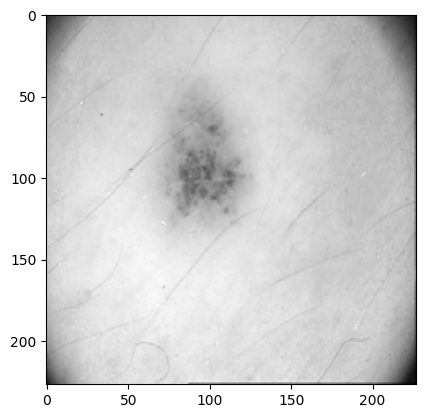

In [44]:
import matplotlib.pyplot as plt
img_array = dataset[4]
plt.imshow(img_array, cmap='gray')  # Use 'cmap' according to your image type (e.g., 'gray' for grayscale)
plt.show()

###Create the data labels list

In [25]:
df = pd.read_excel('/content/content/PH2Dataset/PH2_dataset.xlsx')[12:]
len(df)

200

In [26]:
labels=[]
for i in range(0,200):
    if (np.asarray(df)[i][4]=='X'):
        labels.append(1)
    else:
        labels.append(0)
labels=np.asarray(labels)

##Flatten the images of the dataset

In [27]:
dataset_flat=[]
for i in range(len(dataset)):
    dataset_flat.append(np.asarray(dataset[i]).flatten())
dataset_flat=np.asarray(dataset_flat)

#Create SVM Model with train-to-test raito of 75/25
#Use the first 10 PCA components
#Kernel is rbf

In [28]:
def SVMTrain(dataset_flat,labels,components):
    PCA_Model=PCA(n_components=components)
    X_Train_PCA=PCA_Model.fit_transform(dataset_flat)
    X_train, X_test, y_train, y_test = train_test_split(X_Train_PCA, labels, test_size = 0.25, random_state = 0)
    classifier = SVC(kernel = 'rbf', random_state = 0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    test_accuracy=accuracy_score(y_test,y_pred)
    y_pred_train = classifier.predict(X_train)
    train_accuracy=accuracy_score(y_train,y_pred_train)
    return components,train_accuracy,test_accuracy

##Train the model and print the accuracy, training accuracy is 0.79, testing accuracy is 0.82 at 10 PCA Components

In [29]:
PCA_ComponentsNumber,TrainAccuracy,TestAccuracy=SVMTrain(dataset_flat,labels,10)
print(f"Training Accuracy= {TrainAccuracy},Testing Accuracy= {TestAccuracy} at {PCA_ComponentsNumber} PCA Components")

Training Accuracy= 0.7933333333333333,Testing Accuracy= 0.82 at 10 PCA Components


#Creating AlexNet Model

In [30]:
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import activations
from tensorflow import keras
import keras.layers as layers
model = keras.Sequential()
model.add(layers.Conv2D(filters=96, kernel_size=(11, 11),
                        strides=(4, 4), activation="relu",
                        input_shape=(227, 227, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(5, 5),
                        strides=(1, 1), activation="relu",
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(layers.Conv2D(filters=384, kernel_size=(3, 3),
                        strides=(1, 1), activation="relu",
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=384, kernel_size=(3, 3),
                        strides=(1, 1), activation="relu",
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3),
                        strides=(1, 1), activation="relu",
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization_5 (Bat  (None, 55, 55, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                      

In [31]:
# df = pd.read_excel('/content/content/PH2Dataset/PH2_dataset.xlsx')[12:]
# labels=[]
# for i in range(0,200):
#     if (np.asarray(df)[i][4]=='X'):
#         labels.append(1)
#     else:
#         labels.append(0)
# labels=np.asarray(labels)

##Resize the images to (227,227) to be input to AlexNet Model

In [32]:
dataset=[]
for dirname, _, filenames in os.walk('/content/content/PH2Dataset/PH2 Dataset images'):
    for filename in filenames:
        image = Image.open(os.path.join(dirname, filename))
        image=image.resize((227, 227))
        image= np.asarray(image)
        if (len(image.shape) == 3):
            dataset.append(rgb2gray(image))
dataset[0].shape

(227, 227)

#Convert to np arrays

In [33]:
dataset=np.asarray(dataset)
labels=np.asarray(labels)

##Split the data to training/ testing/ validation at ratios 80/10/10

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.20, random_state = 0)
X_valid, X_verif, y_valid, y_verif = train_test_split(X_test, y_test, test_size = 0.50, random_state = 0)

In [35]:
model.fit(X_train,y_train,epochs=50)


Epoch 1/50
5/5 [==============================] - 31s 5s/step - loss: 6.2393 - accuracy: 0.6750
Epoch 2/50
5/5 [==============================] - 28s 6s/step - loss: 3.0431 - accuracy: 0.7500
Epoch 3/50
5/5 [==============================] - 29s 6s/step - loss: 2.4115 - accuracy: 0.6562
Epoch 4/50
5/5 [==============================] - 28s 5s/step - loss: 1.0139 - accuracy: 0.7688
Epoch 5/50
5/5 [==============================] - 28s 6s/step - loss: 0.9262 - accuracy: 0.8062
Epoch 6/50
5/5 [==============================] - 26s 5s/step - loss: 0.5395 - accuracy: 0.8000
Epoch 7/50
5/5 [==============================] - 29s 6s/step - loss: 0.7339 - accuracy: 0.8000
Epoch 8/50
5/5 [==============================] - 26s 5s/step - loss: 1.0018 - accuracy: 0.7875
Epoch 9/50
5/5 [==============================] - 46s 9s/step - loss: 0.7054 - accuracy: 0.8000
Epoch 10/50
5/5 [==============================] - 38s 8s/step - loss: 0.3294 - accuracy: 0.8687
Epoch 11/50
5/5 [======================

In [36]:
prediction_train= np.around(model.predict(X_train)).reshape(160).astype(int)


5/5 [==============================] - 8s 2s/step


In [37]:
prediction_valid= np.around(model.predict(X_valid)).reshape(20).astype(int)


1/1 [==============================] - 1s 904ms/step


##Finding Training, Testing and validation accuracy

In [38]:
accuracy_train=0
for i in range(len(prediction_train)):
    if y_train[i]== prediction_train[i]:
        accuracy_train+=1
accuracy_train=accuracy_train/len(prediction_train)

In [39]:
accuracy_valid=0
for i in range(len(prediction_valid)):
    if y_valid[i]== int(round(prediction_valid[i])):
        accuracy_valid+=1
accuracy_valid=accuracy_valid/len(prediction_valid)
print(f"accuracy of training set is {accuracy_train}")
print(f"accuracy of validation set is {accuracy_valid}")

accuracy of training set is 0.65625
accuracy of validation set is 0.55


In [40]:
prediction_verif= np.around(model.predict(X_verif)).reshape(20).astype(int)
accuracy_verif=0
for i in range(len(prediction_verif)):
    if y_verif[i]== prediction_verif[i]:
        accuracy_verif+=1
accuracy_verif=accuracy_verif/len(prediction_verif)
print(f"accuracy of verification set is {accuracy_verif}")

1/1 [==============================] - 1s 770ms/step
accuracy of verification set is 0.6


#Artificial Neural Network

##Neccesary imports

In [45]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf


Reload the original dataset

In [46]:
dataset=[]
for dirname, _, filenames in os.walk('/content/content/PH2Dataset/PH2 Dataset images'):
    for filename in filenames:
        image = Image.open(os.path.join(dirname, filename))
        image=image.resize((575, 765))
        image= np.asarray(image)
        if (len(image.shape) == 3):
            dataset.append(rgb2gray(image))

##Flatten the dataset again

In [47]:
dataset_flat=[]
for i in range(len(dataset)):
    dataset_flat.append(np.asarray(dataset[i]).flatten())
dataset_flat=np.asarray(dataset_flat)

##Create the ANN

In [48]:
model= Sequential(
    [
        Dense(15,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        Dense(10,activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        Dense(1,activation='sigmoid',  kernel_regularizer=tf.keras.regularizers.L2(0.1))
    ],name='my_model'
)

In [49]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)
PCA_Model=PCA(n_components=10)
X_Train_PCA=PCA_Model.fit_transform(dataset_flat)
X_train, X_test, y_train, y_test = train_test_split(X_Train_PCA, labels, test_size = 0.25, random_state = 0)
model.fit(X_train,y_train,epochs=500)

Epoch 1/500
5/5 [==============================] - 2s 5ms/step - loss: 6.5584
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 5.8971
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 5.3563
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 4.9676
Epoch 5/500
5/5 [==============================] - 0s 5ms/step - loss: 4.6648
Epoch 6/500
5/5 [==============================] - 0s 4ms/step - loss: 4.4780
Epoch 7/500
5/5 [==============================] - 0s 4ms/step - loss: 4.2780
Epoch 8/500
5/5 [==============================] - 0s 5ms/step - loss: 4.1409
Epoch 9/500
5/5 [==============================] - 0s 4ms/step - loss: 4.0159
Epoch 10/500
5/5 [==============================] - 0s 4ms/step - loss: 3.9046
Epoch 11/500
5/5 [==============================] - 0s 4ms/step - loss: 3.7807
Epoch 12/500
5/5 [==============================] - 0s 4ms/step - loss: 3.6848
Epoch 13/500
5/5 [==============================] - 0s 5ms/st

In [51]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
for i in range (len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    else:
        y_pred[i]=0
for i in range (len(y_pred_train)):
    if y_pred_train[i]>0.5:
        y_pred_train[i]=1
    else:
        y_pred_train[i]=0

5/5 [==============================] - 0s 3ms/step


##Calculate the training and testing accuracy

In [52]:
sum_train=0
for i in range (len(y_pred_train)):
    if (y_pred_train[i]==y_train[i]):
        sum_train+=1
print(f"Accuracy of training set is {sum_train/len(y_pred_train)}")

Accuracy of training set is 0.8333333333333334


In [53]:
sum_train=0
for i in range (len(y_pred)):
    if (y_pred[i]==y_test[i]):
        sum_train+=1
print(f"Accuracy of testing set is {sum_train/len(y_pred)}")

Accuracy of testing set is 0.76
